<h2 align="center">
	Unitary Preparation of Tensor Network States
</h2>

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl

import quimb.tensor as qtn

from qsp.misc_states import make_aklt_mps
from qsp.misc_states import make_aklt_peps
from qsp.tsp import MPSPreparation, PEPSPreparation
from qsp.tsp_helper_routines import make_splitted_mps

Given the requirements load/construct MPS of cetain length.

In [3]:
def get_target_mps(mps_type):

    if mps_type == "aklt":
        tensor_array, _ = make_aklt_mps(L=12)
        tensor_array = make_splitted_mps(tensor_array)
        target_mps = qtn.MatrixProductState(tensor_array, shape="lrp")

    if mps_type == "random":
        target_mps = qtn.MPS_rand_state(L=12, bond_dim=4)
        target_mps.permute_arrays(shape="lrp")

    if mps_type in ["P4", "N2", "heisenberg"]:
        filenames = {
            "P4": "data/P4_6-31G_dist2.0000.pkl",
            "N2": "data/N2_STO-6G_dist2.0000.pkl",
            "heisenberg": "data/heisenberg_L32_dist0.8000.pkl",
        }
        with open(filenames[mps_type], "rb") as f:
            data = pkl.load(f)
        target_mps = data["quimb_mps"]

    return target_mps

<h2 align="center">
	Matrix Product States
</h2>
<h3 align="left">
	1. Sequential preparation
</h3>


$$
| \psi[A] \rangle \approx  (U_0. U_1. … U_D) |00...0\rangle
$$


where $D$ is the number of layers of unitaries $U_i$ (see [[1]], [[2]]).
 

[1]: https://arxiv.org/pdf/2209.07106.pdf
[2]: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.101.032310

In [9]:
target_mps = get_target_mps(mps_type='aklt')
prep = MPSPreparation(target_mps)
num_seq_layers = 6
seq_data = prep.sequential_unitary_circuit(num_seq_layers)

preparing mps using sequential unitaries (num_seq_layers=6)...


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:16<00:00,  2.69s/it]


overlap from static seq. preparation = 0.75873580,
n_gates=1143, n_2qg=373



In [8]:
circ = seq_data["circ"]
circ.size()

1143

<h3 align="left">
	2. Variational optimization over sequentially prepared unitaries
</h3>

In [10]:
target_mps = get_target_mps(mps_type='aklt')
prep = MPSPreparation(target_mps)
num_var_seq_layers = 2
var_seq_data = prep.sequential_unitary_circuit_optimization(num_var_seq_layers, max_iterations=4)

doing variational optimization over sequential unitaries (num_var_seq_layers=2)...


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.49it/s]


number of variational params in the circuit (from sequential algorithm) are 939
overlap before variational optimization = -0.6592717767


-0.154138788581 [best: -0.842006504536] : : 19it [02:13,  7.02s/it]                    


overllap after variational optimization = 0.84200650,
n_gates=354, n_2qg=110



{'tnopt': <TNOptimizer(d=939, backend=tensorflow)>,
 'optimized_unitary': TensorNetworkGenOperator(tensors=533, indices=667),
 'circ': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f3577ffd8d0>,
 'overlap_from_seq_circ': None}

<h3 align="left">
	3. Quantum Circuit Tensor Network Ansatz
</h3>

In [12]:
target_mps = get_target_mps(mps_type='aklt')
prep = MPSPreparation(target_mps)
qctn_depth = 8
qctn_data = prep.quantum_circuit_tensor_network_ansatz(qctn_depth, max_iterations=4)

preparing mps using quantum circuit tensor network ansatz (qctn_depth=8)...
number of variational params in the circuit (from QCTN) are 1200
overlap before variational optimization = -0.0000750047


-0.009121494368 [best: -0.009121494368] : : 14it [01:21,  5.81s/it]                    


overllap after qctn optimization =0.00912149,
n_gates=400, n_2qg=184



<h3 align="left">
	4. Preparation using Linear Combinition of unitaries (LCU)
</h3>

\begin{aligned}
	|\psi[A] \rangle = \left( U_0 + \kappa_1U_1 + \kappa_2U_2 + \dots\right)|00\dots0\rangle,
\end{aligned}

see [[1]] for details

[1]: https://arxiv.org/pdf/2209.07106.pdf


In [14]:
target_mps = get_target_mps(mps_type='N2')
prep = MPSPreparation(target_mps)
num_lcu_layers = 4
lcu_data = prep.lcu_unitary_circuit(num_lcu_layers)

preparing mps as linear combination of unitaries (num_lcu_layers=4)...


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


overllap after lcu. preparation = 0.84256240,  n_gates=3002, n_2qg=1242



<h3 align="left">
	5. Variational optimization over LCU construction
</h3>

In [15]:
target_mps = get_target_mps(mps_type='N2')
num_var_lcu_layers = 4
data_var_lcu = prep.lcu_unitary_circuit_optimization(num_var_lcu_layers, max_iterations=4)

doing variational optimization over linear combination of unitaries (num_var_lcu_layers=4)...


100%|██████████| 4/4 [00:07<00:00,  1.97s/it]


overlap before lcu optimization = 0.8425623986 , n_gates=3052, n_2qg=1262


100%|██████████| 4/4 [01:03<00:00, 15.97s/it]

final overlap (after 4 iters):  -0.84247412348052764


overllap after lcu optimization (qgopt) = 0.84238025



<h3 align="left">
	6. Adiabatic state Preparation of MPS
</h3>

In [16]:
target_mps = qtn.MPS_rand_state(L=6, bond_dim=2)
prep = MPSPreparation(target_mps)
runtime, tau = 8, 0.04  # total runtime, trotter step size
max_bond = 2
adiabatic_data = prep.adiabatic_state_preparation(runtime, tau, max_bond, verbose=False)

adiabatic state preparation of mps:
runtime=8, tau=0.04, steps=200, max_bond_dim=2
given mps is not injective. blocking it now ...


100%|██████████| 201/201 [00:22<00:00,  8.76it/s]


final overlap @ s=1.00000 is e=0.00000000, curr_f=0.99833848, target_fidelity=0.99833848
approximate n_gates=213060, and n_2qg=80400



Text(0, 0.5, 'current fidelity')

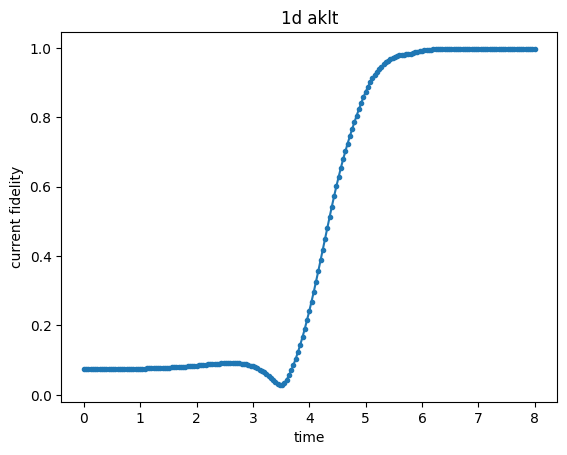

In [8]:
plt.plot(adiabatic_data["target_fidelity"].keys(), adiabatic_data["target_fidelity"].values(), ".-")
plt.title("1d aklt")
plt.xlabel("time")
plt.ylabel("current fidelity")

In [9]:
tensor_array, _ = make_aklt_mps(L=6)
prep = MPSPreparation(tensor_array, shape="lrp")
Tmax, tau = 8, 0.04  # total runtime, trotter step size
max_bond = 2
prep.adiabatic_state_preparation(Tmax, tau, max_bond, verbose=False)

adiabatic state preparation of mps:
runtime=8, tau=0.04, steps=200, max_bond=2


100%|██████████| 201/201 [00:40<00:00,  4.99it/s]


final overlap @ s=1.00000 is e=0.00000000, curr_f=0.99658790, target_fidelity=0.99658790
approximate n_gates=532650, and n_2qg=201000



<h2 align="center">
	Projected Entangled Pair States (PEPS) in 2d
</h2>
<h3 align="left">
	1. Adiabatic state Preparation
</h3>

In [10]:
Lx, Ly = 10, 4
target_grid, _ = make_aklt_peps(Lx, Ly)
prep = PEPSPreparation(target_grid)

Tmax, tau = 10, 0.04
max_bond = 2
prep.adiabatic_state_preparation(Tmax, tau, max_bond, verbose=False)

adiabatic state preparation of peps:
runtime=10, tau=0.04, steps=250, max_bond=2


100%|██████████| 251/251 [1:36:16<00:00, 23.01s/it]


2d adiabatic preparation: @ s=1.00000, e=0.00505010, fidelity=0.99099760


Text(0, 0.5, 'current fidelity')

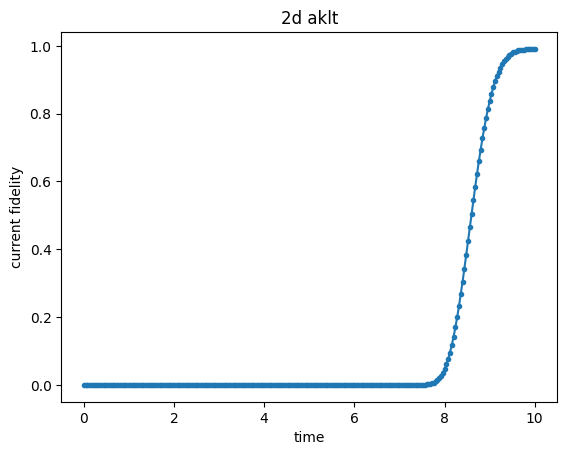

In [11]:
plt.plot(
    prep.adiabatic_data["target_fidelity"].keys(),
    prep.adiabatic_data["target_fidelity"].values(),
    ".-",
)
plt.title("2d aklt")
plt.xlabel("time")
plt.ylabel("current fidelity")